# Laboration deep learning AI21

## 0. EDA och filhantering

Creating the folders with python :

In [55]:
import os , random, shutil, glob 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
parent_dir = os.getcwd() #get actual directory
main_folders = ["experiment_small_data","experiment_tiny_data","original_data"]
subfolders = ["experiment_small_data/test","experiment_small_data/train","experiment_small_data/val","experiment_tiny_data/test","experiment_tiny_data/train","experiment_tiny_data/val","original_data/train","original_data/test"]

for main_f in main_folders :
    for sub_f in subfolders : 
        sub_f_list = sub_f.split("/") # turn subfolder path into list of folders
        if main_f in sub_f_list : 
            directory_name = sub_f_list[1] #actual directory to make is the 2nd in the list
            path = os.path.join(parent_dir,main_f,directory_name) #creating the folder path
            if not os.path.isdir(path): # check if path doesn't already exist
                try: 
                    os.makedirs(path) #create all missing folders in the folder path 
                except OSError as error: 
                    print(error)

Read in 10 pictures randomly and plot them out, use the label as plot title :

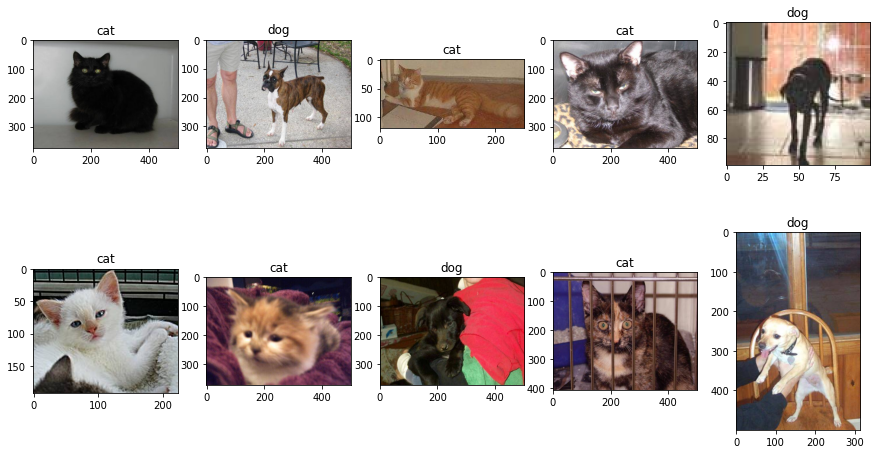

In [29]:
folder = "original_data/train/train"

files = random.sample(range(1, 12500), 10)

fig, axes = plt.subplots(2,5, figsize=(15,8))

for file_number,(i, ax) in zip(files,enumerate(axes.flatten())) : 
    animal = random.choice(["cat","dog"])
    file_path = os.path.join(folder,animal+"."+str(file_number)+".jpg")
    image = plt.imread(file_path)
    ax.imshow(image)
    ax.set_title(f"{animal}")


Split the data into train / validation / test :

In [56]:
# splitting the data 

source_folder = os.path.join(parent_dir,folder)

for data in ["experiment_small_data","experiment_tiny_data"]:
    folder_for = lambda x : os.path.join(parent_dir,data,x)

    cats = ["cat"+"."+str(x)+".jpg" for x in random.sample(range(1,12500),1250)]
    dogs = ["dog"+"."+str(x)+".jpg" for x in random.sample(range(1,12500),1250)]

    if len(os.listdir(folder_for("train")) ) == 0:
        for cat_picture,dog_picture in zip(cats[:800],dogs[:800]):
            shutil.copy(os.path.join(source_folder,cat_picture),folder_for("train"))
            shutil.copy(os.path.join(source_folder,dog_picture),folder_for("train"))
        
        for cat_picture,dog_picture in zip(cats[800:1000],dogs[800:1000]):
            shutil.copy(os.path.join(source_folder,cat_picture),folder_for("val"))
            shutil.copy(os.path.join(source_folder,dog_picture),folder_for("val"))

        for cat_picture,dog_picture in zip(cats[1000:1250],dogs[1000:1250]):
            shutil.copy(os.path.join(source_folder,cat_picture),folder_for("test"))
            shutil.copy(os.path.join(source_folder,dog_picture),folder_for("test")) 

    else : 
        print(data," folders already filled, please empty the folders from data and try again")

experiment_small_data  folders already filled, please empty the folders from data and try again
experiment_tiny_data  folders already filled, please empty the folders from data and try again


Read in the datasets and get the label then one-hot encode them. 

As we're creating the dataset i decided to resize all the images while reading them in. Let's check how the size distribution looks like :

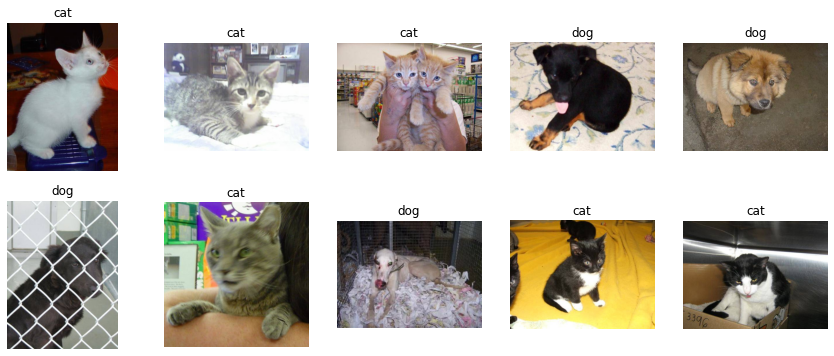

In [39]:
s_images = random.sample(glob.glob(parent_dir+"/"+"experiment_small_data"+"/train/*.jpg"),5)
t_images = random.sample(glob.glob(parent_dir+"/"+"experiment_tiny_data"+"/val/*.jpg"),5)

fig,ax = plt.subplots(2,5,figsize = (15,6))
ax = ax.flatten()

for path,axe in zip(s_images,ax[:5]) : 
    label = path.split("/")[-1].split(".")[0]
    image = plt.imread(path)
    axe.imshow(image)
    axe.set_title(label)
    axe.axis("off")

for path,axe in zip(t_images,ax[5:]) : 
    label = path.split("/")[-1].split(".")[0]
    image = plt.imread(path)
    axe.imshow(image)
    axe.set_title(label)
    axe.axis("off")



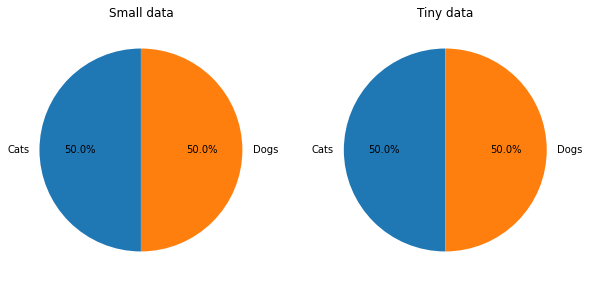

In [40]:
#Checking if the data is well balanced 

def get_proportions(folder_path):
        data_dogs = 0
        data_cats = 0
        for file_path in glob.glob(parent_dir+"/"+folder_path+"/train/*.jpg"): 
                animal = file_path.split("/")[-1].split(".")[0]
                if animal == "dog" : 
                        data_dogs += 1
                else : 
                        data_cats += 1 
        return [data_cats,data_dogs]

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax = ax.flatten()
ax[0].pie(get_proportions("experiment_small_data"), 
        labels=["Cats","Dogs"], 
        startangle=90, 
        autopct='%1.1f%%'
        )
ax[0].set_title("Small data")
ax[1].pie(get_proportions("experiment_tiny_data"), 
        labels=["Cats","Dogs"], 
        startangle=90, 
        autopct='%1.1f%%'
        )
ax[1].set_title("Tiny data")
plt.show()

In [57]:
animal_name = lambda x: x.split("/")[-1].split(".")[0]
small = "experiment_small_data"
tiny = "experiment_tiny_data"

def create_dataframe(folder,subfolder):
    data = shuffle([[file_path,1 if animal_name(file_path)=="dog" else 0] for file_path in glob.glob(parent_dir+"/"+folder+"/"+subfolder+"/*.jpg")])
    df = pd.DataFrame(data,columns=["Path","Label"])
    return df

df_dict = {}
for folder in [small,tiny]: 
    for subfolder in ["train","val","test"]: 
        df_dict[f"{folder}_{subfolder}_df"] = create_dataframe(folder,subfolder)

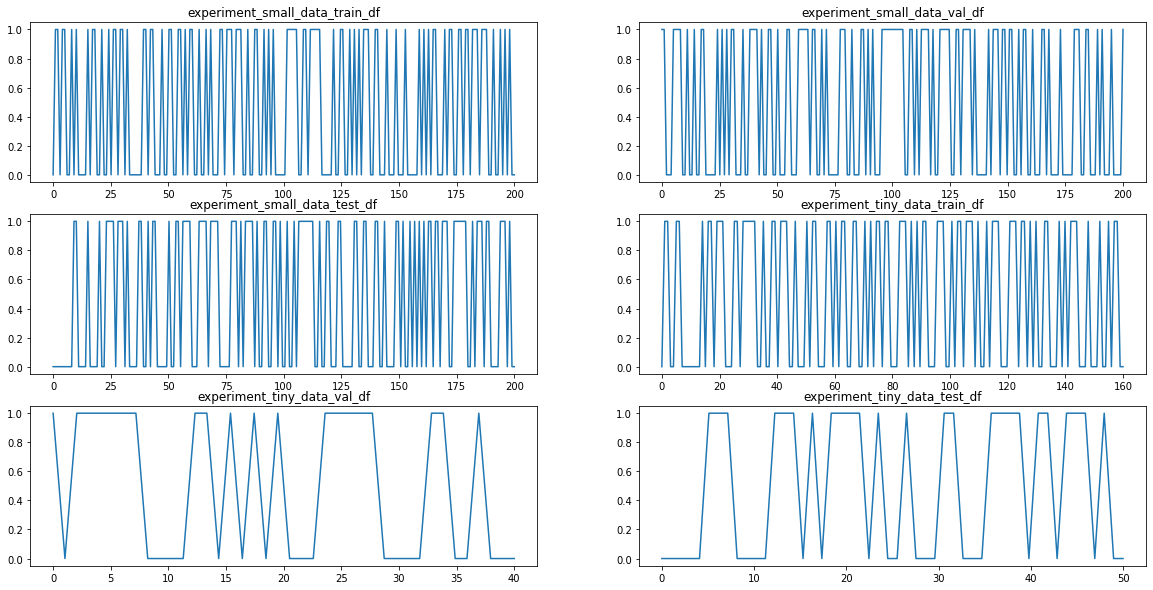

In [58]:
fig,ax = plt.subplots(3,2,figsize=(20,10))
ax = ax.flatten() 

for key,axis in zip(df_dict,ax) : 
    y = df_dict[key].Label[:min(200,len(df_dict[key]))]
    x = np.linspace(0,len(y),len(y))
    axis.plot(x,y) 
    axis.set_title(key)

plt.show()